# Checknews

> Plataforma web para detecção de fake news

### Bibliotecas básicas e outros imports

In [1]:
"""
    Bibliotecas básicas de DS
"""
import warnings
import pandas as pd
import numpy as np


"""
 Bibliotecas para melhora da performance e análise do dataset
"""
import sidetable
from pandarallel import pandarallel
from deepchecks.tabular import Dataset
from deepchecks.tabular.suites import data_integrity, train_test_validation

"""
    Bibliotecas de visualização de dados
"""
import matplotlib.pyplot as plt
%matplotlib inline

"""
    Biblioteca MLOps
"""
import mlflow
import mlflow.sklearn

"""
    Bibliotecas de ML
"""
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, log_loss

"""
    Arquivo de pré-processamento
"""
%run modules/nlp/pre_processing/pre_processor.py
%run modules/nlp/data_handler.py

"""
    Configurações básicas
"""
warnings.filterwarnings('ignore')
pandarallel.initialize(progress_bar=True)

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
np.set_printoptions(suppress=True, precision=3)

deepchecks - WARNING - You are using deepchecks version 0.12.0, however a newer version is available.Deepchecks is frequently updated with major improvements. You should consider upgrading via the "python -m pip install --upgrade deepchecks" command.


INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/liliane_aquino/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
## A pessoa vai passar o link de uma página web e precisarei usar um scrapping 
# ou outro mecanismo para pegar o conteúdo de texto dessa página e passar para o classificador.

#1. Pega a url e extrai o texto
#2. Trata o texto extraido
#3. Passa para o classificador
#4. Retorna a classificação e confiança

### Dados para teste

In [3]:
df = pd.read_excel('data/data_fake_news_final.xlsx')
df = df.iloc[np.random.permutation(df.index)].reset_index(drop=True)
print(f'Linhas: {df.shape[0]} | Coluna:  {df.shape[1]}')
df.head(1)

Linhas: 50672 | Coluna:  3


,text,origin,label
0,"— Steven (@superaielman) October 26, 2016 \nEa...",sf4t9rfan,fake


### Elimina colunas desnecessários e preenche nulos para origem

In [4]:
df['origin'].fillna('origem desconhecida', inplace=True)

### Valores nulos

In [5]:
df.stb.missing()

,missing,total,percent
text,1,50672,0.001973
origin,0,50672,0.000000
label,0,50672,0.000000


### Analisando a integridade dos dados

In [6]:
ds = Dataset(df, label='label')

integ_suite = data_integrity()
suite_result = integ_suite.run(ds)
suite_result.show()

deepchecks - WARNING - It is recommended to initialize Dataset with categorical features by doing "Dataset(df, cat_features=categorical_list)". No categorical features were passed, therefore heuristically inferring categorical features in the data. 0 categorical features were inferred.


Accordion(children=(VBox(children=(HTML(value='\n<h1 id="summary_7OR8BWB7GRTH4VPZLOUX6G93Y">Data Integrity Sui…

### Pré-processamento

In [7]:
df['text'] = df['text'].parallel_apply(cleaning)
df['origin'] = df['origin'].parallel_apply(prepareData)
df.sample(2)

,text,origin,label
44174,linkTag the following information new and chil...,noreply@blogger.com alexander light,fake
25126,after acclaimed run the good wife comes end su...,lorne manly,verdadeira


### Remove dados duplicados

In [8]:
df.drop_duplicates(subset=['text', 'origin'], inplace=True)
print(f'Linhas: {df.shape[0]} | Coluna:  {df.shape[1]}')

Linhas: 50590 | Coluna:  3


### Balanceamento dos dados

In [9]:
df['label'].value_counts()

fake          33896
verdadeira    16694
Name: label, dtype: int64

### Seleção das classes

In [10]:
min_class_count = 16693
df_filtered = df.groupby('label').apply(lambda x: x.sample(min_class_count)).reset_index(drop=True)
df_filtered['label'].value_counts()

fake          16693
verdadeira    16693
Name: label, dtype: int64

### Encoder dos dados

In [11]:
y = labelEncoder(df_filtered['label'])

### Divisão base

In [12]:
df_filtered.drop(['label'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = kFoldSplitTrainTest(df_filtered,
                                                       y,
                                                       ['text', 'origin'])

### Validando os dados de treino e testes

In [13]:
train_ds = Dataset(X_train.reset_index(drop=True), label=y_train, cat_features=[])
test_ds = Dataset(X_test.reset_index(drop=True), label=y_test, cat_features=[])

validation_suite = train_test_validation()
suite_result = validation_suite.run(train_ds, test_ds)
suite_result

Accordion(children=(VBox(children=(HTML(value='\n<h1 id="summary_FDOJENGD3W816L4CGLJCU6LB2">Train Test Validat…

### MLOPS

In [14]:
dataset = 'data_fake_news_final.xlsx'
version = 'v1'
title = 'experimentos_checknews'

#### Decision tree

2023/04/17 19:31:39 INFO mlflow.tracking.fluent: Experiment with name 'experimentos_checknews' does not exist. Creating a new experiment.


              precision    recall  f1-score   support

        fake       0.88      0.88      0.88      3338
  verdadeira       0.88      0.88      0.88      3339

    accuracy                           0.88      6677
   macro avg       0.88      0.88      0.88      6677
weighted avg       0.88      0.88      0.88      6677

Modelo:  0bdea86933d4463099d7422b5eca5980


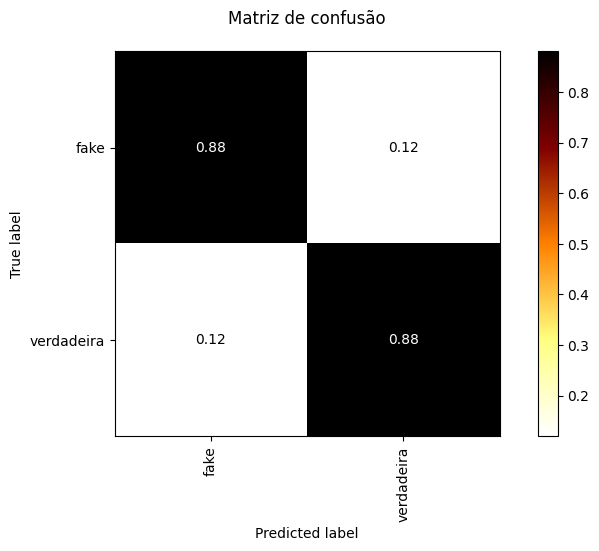

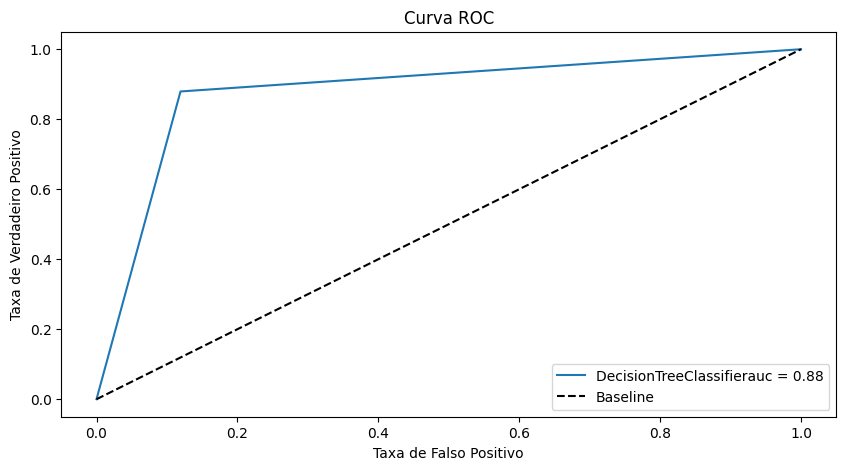

In [15]:
mlflow.set_experiment(title)
with mlflow.start_run(run_name='DecisionTreeClassifier'):
    mlflow.set_tags({'dataset': dataset, 'version': version})
    
    column_transformer = ColumnTransformer([
        ('vectorizer_col1', TfidfVectorizer(stop_words = STOPWORDS, lowercase = False), 0),
        ('vectorizer_col2', TfidfVectorizer(stop_words = STOPWORDS, lowercase = False), 1),
    ])

    criterion = 'gini'
    splitter = 'random'

    dt_classifier_pipeline = Pipeline([
        ('vectorizer', column_transformer),
        ('clf', CalibratedClassifierCV(DecisionTreeClassifier(criterion=criterion, splitter=splitter), method='isotonic', cv=5))
    ])

    mlflow.log_param('criterion', criterion)
    mlflow.log_param('splitter', splitter)


    dt_classifier_pipeline.fit(X_train.values, y_train)
    y_pred = dt_classifier_pipeline.predict(X_test)
    y_prob = dt_classifier_pipeline.predict_proba(X_test)

    accuracy, recall, precision, f1, log, auc = getMetrics(y_test, y_pred, y_prob)

    mlflow.log_metric('acuracia', accuracy)
    mlflow.log_metric('recall', recall)
    mlflow.log_metric('precisão', precision)
    mlflow.log_metric('f1', f1)
    mlflow.log_metric('log', log)
    mlflow.log_metric('auc', auc)
    
    confusionMatrix('Matriz de confusão', dt_classifier_pipeline, X_test, y_test, y.classes)
    plt.savefig('img/matriz_classifier_dt.png')

    print(getClassificationReport(y_test, y_pred, y.classes))
    
    curvaRoc('DecisionTreeClassifier', y_test, y_pred, auc)
    plt.savefig('img/curva_roc_dt.png')

    mlflow.log_artifact(local_path='img/matriz_classifier_dt.png', artifact_path='img')
    mlflow.log_artifact(local_path='data/'+dataset, artifact_path='data')
    mlflow.log_artifact(local_path='img/curva_roc_dt.png', artifact_path='img')
    mlflow.sklearn.log_model(dt_classifier_pipeline, 'model_dt')
    print('Modelo: ', mlflow.active_run().info.run_uuid)

#### SVC

              precision    recall  f1-score   support

        fake       0.90      0.94      0.92      3338
  verdadeira       0.94      0.89      0.92      3339

    accuracy                           0.92      6677
   macro avg       0.92      0.92      0.92      6677
weighted avg       0.92      0.92      0.92      6677

Modelo:  3abec0040fc24bcda94009d44e533fbb


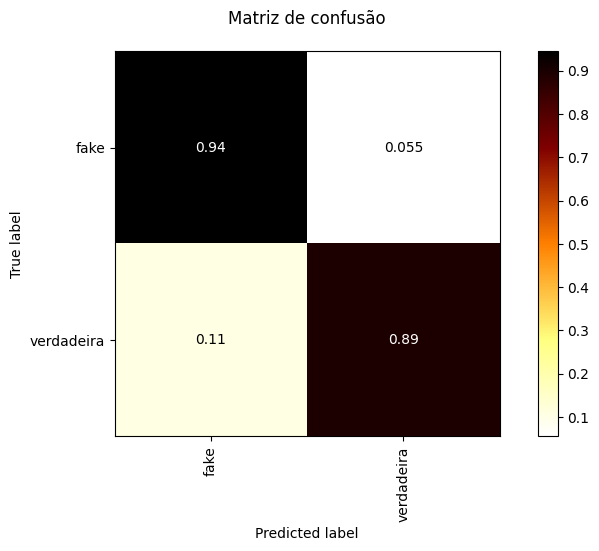

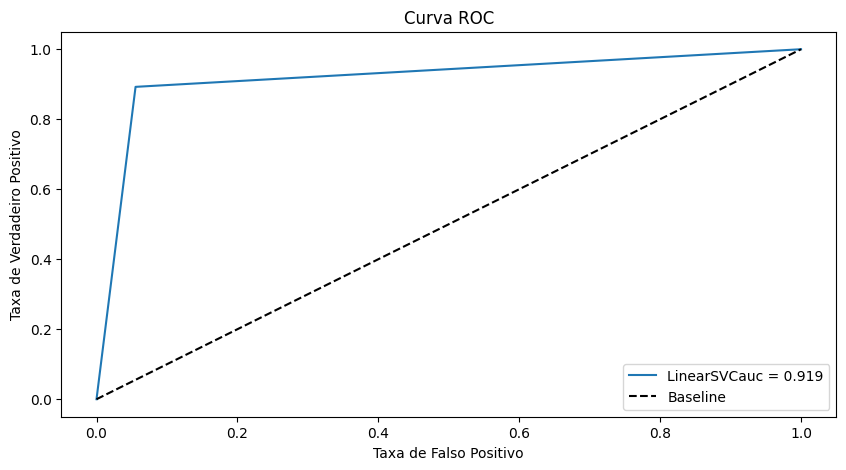

In [16]:
mlflow.set_experiment(title)
with mlflow.start_run(run_name='LinearSVC'):
    mlflow.set_tags({'dataset': dataset, 'version': version})

    column_transformer = ColumnTransformer([
        ('vectorizer_col1', TfidfVectorizer(stop_words = STOPWORDS, lowercase = False), 0),
        ('vectorizer_col2', TfidfVectorizer(stop_words = STOPWORDS, lowercase = False), 1),
    ])

    penalty = 'l2'
    loss = 'squared_hinge'

    svc_classifier_pipeline = Pipeline([
        ('vectorizer', column_transformer),
        ('clf', CalibratedClassifierCV(LinearSVC(penalty=penalty, loss=loss), method='isotonic', cv=5))
    ])

    mlflow.log_param('penalty', penalty)
    mlflow.log_param('loss', loss)

    svc_classifier_pipeline.fit(X_train.values, y_train)
    y_pred = svc_classifier_pipeline.predict(X_test)
    y_prob = svc_classifier_pipeline.predict_proba(X_test)

    accuracy, recall, precision, f1, log, auc = getMetrics(y_test, y_pred, y_prob)

    mlflow.log_metric('acuracia', accuracy)
    mlflow.log_metric('recall', recall)
    mlflow.log_metric('precisão', precision)
    mlflow.log_metric('f1', f1)
    mlflow.log_metric('log', log)
    mlflow.log_metric('auc', auc)

    confusionMatrix('Matriz de confusão', svc_classifier_pipeline, X_test, y_test, y.classes)
    plt.savefig('img/matriz_classifier_svc.png')

    print(getClassificationReport(y_test, y_pred, y.classes))
    
    curvaRoc('LinearSVC', y_test, y_pred, auc)
    plt.savefig('img/curva_roc_svc.png')

    mlflow.log_artifact(local_path='img/matriz_classifier_svc.png', artifact_path='img')
    mlflow.log_artifact(local_path='data/'+dataset, artifact_path='data')
    mlflow.log_artifact(local_path='img/curva_roc_svc.png', artifact_path='img')
    mlflow.sklearn.log_model(svc_classifier_pipeline, 'model_svc')
    print('Modelo: ', mlflow.active_run().info.run_uuid)

#### Naive Bayes

              precision    recall  f1-score   support

        fake       0.80      0.94      0.86      3338
  verdadeira       0.93      0.76      0.84      3339

    accuracy                           0.85      6677
   macro avg       0.86      0.85      0.85      6677
weighted avg       0.86      0.85      0.85      6677

Modelo:  556a767c2e92400c91647db459ad183a


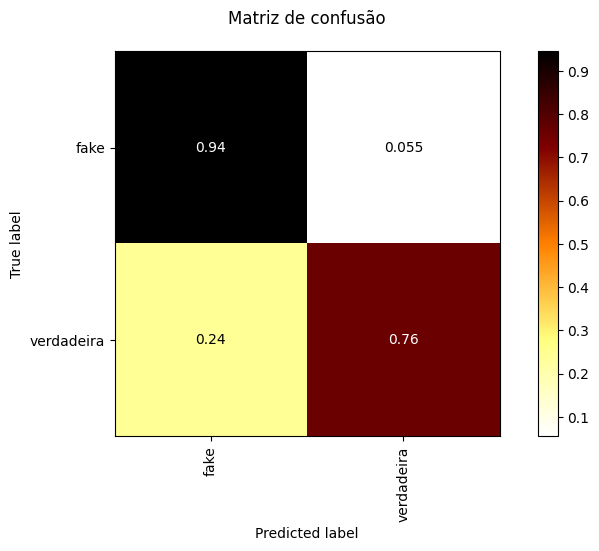

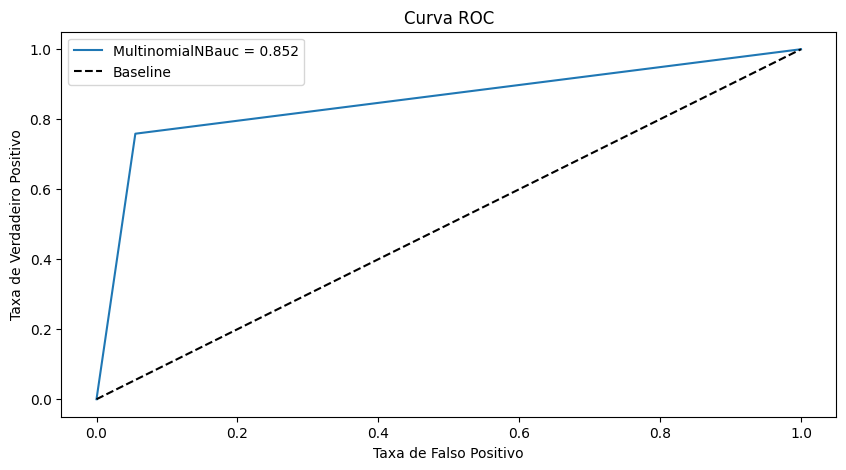

In [17]:
mlflow.set_experiment(title)
with mlflow.start_run(run_name='MultinomialNB'):
    mlflow.set_tags({'dataset': dataset, 'version': version})

    column_transformer = ColumnTransformer([
        ('vectorizer_col1', TfidfVectorizer(stop_words = STOPWORDS, lowercase = False), 0),
        ('vectorizer_col2', TfidfVectorizer(stop_words = STOPWORDS, lowercase = False), 1),
    ])

    alpha = 1.0
    force_alpha = 'warn'

    nb_classifier_pipeline = Pipeline([
        ('vectorizer', column_transformer),
        ('clf', CalibratedClassifierCV(MultinomialNB(alpha=alpha, force_alpha=force_alpha), method='isotonic', cv=5))
    ])

    mlflow.log_param('alpha', alpha)
    mlflow.log_param('force_alpha', force_alpha)

    nb_classifier_pipeline.fit(X_train.values, y_train)
    y_pred = nb_classifier_pipeline.predict(X_test)
    y_prob = nb_classifier_pipeline.predict_proba(X_test)

    accuracy, recall, precision, f1, log, auc = getMetrics(y_test, y_pred, y_prob)

    mlflow.log_metric('acuracia', accuracy)
    mlflow.log_metric('recall', recall)
    mlflow.log_metric('precisão', precision)
    mlflow.log_metric('f1', f1)
    mlflow.log_metric('log', log)
    mlflow.log_metric('auc', auc)

    confusionMatrix('Matriz de confusão', nb_classifier_pipeline, X_test, y_test, y.classes)
    plt.savefig('img/matriz_classifier_nb.png')

    print(getClassificationReport(y_test, y_pred, y.classes))
    
    curvaRoc('MultinomialNB', y_test, y_pred, auc)
    plt.savefig('img/curva_roc_nb.png')

    mlflow.log_artifact(local_path='img/matriz_classifier_nb.png', artifact_path='img')
    mlflow.log_artifact(local_path='data/'+dataset, artifact_path='data')
    mlflow.log_artifact(local_path='img/curva_roc_nb.png', artifact_path='img')
    mlflow.sklearn.log_model(nb_classifier_pipeline, 'model_nb')
    print('Modelo: ', mlflow.active_run().info.run_uuid)

#### Random Forest

In [ ]:
mlflow.set_experiment(title)
with mlflow.start_run(run_name='RandomForestClassifier'):
    mlflow.set_tags({'dataset': dataset, 'version': version })
    
    column_transformer = ColumnTransformer([
        ('vectorizer_col1', TfidfVectorizer(stop_words = STOPWORDS, lowercase = False), 0),
        ('vectorizer_col2', TfidfVectorizer(stop_words = STOPWORDS, lowercase = False), 1),
    ])

    n_estimators = 300
    criterion = 'entropy'

    rf_classifier_pipeline = Pipeline([
        ('vectorizer', column_transformer),
        ('clf', CalibratedClassifierCV(RandomForestClassifier(n_estimators=n_estimators, criterion=criterion), method='isotonic', cv=5))
    ])

    mlflow.log_param('n_estimators', n_estimators)
    mlflow.log_param('criterion', criterion)

    rf_classifier_pipeline.fit(X_train.values, y_train)
    y_pred = rf_classifier_pipeline.predict(X_test)
    y_prob = rf_classifier_pipeline.predict_proba(X_test)

    accuracy, recall, precision, f1, log, auc = getMetrics(y_test, y_pred, y_prob)

    mlflow.log_metric('acuracia', accuracy)
    mlflow.log_metric('recall', recall)
    mlflow.log_metric('precisão', precision)
    mlflow.log_metric('f1', f1)
    mlflow.log_metric('log', log)
    mlflow.log_metric('auc', auc)

    confusionMatrix('Matriz de confusão', rf_classifier_pipeline, X_test, y_test, y.classes)
    plt.savefig('img/matriz_classifier_rf.png')

    print(getClassificationReport(y_test, y_pred, y.classes))

    curvaRoc('RandomForestClassifier', y_test, y_pred, auc)
    plt.savefig('img/curva_roc_rf.png')

    mlflow.log_artifact(local_path='img/matriz_classifier_rf.png', artifact_path='img')
    mlflow.log_artifact(local_path='data/'+dataset, artifact_path='data')
    mlflow.log_artifact(local_path='img/curva_roc_rf.png', artifact_path='img')
    mlflow.sklearn.log_model(rf_classifier_pipeline, 'model_rf')
    print('Modelo: ', mlflow.active_run().info.run_uuid)

#### MLP

In [ ]:
mlflow.set_experiment(title)
with mlflow.start_run(run_name='MLPClassifier'):
    mlflow.set_tags({'dataset': dataset, 'version': version })
    
    column_transformer = ColumnTransformer([
        ('vectorizer_col1', TfidfVectorizer(stop_words = STOPWORDS, lowercase = False), 0),
        ('vectorizer_col2', TfidfVectorizer(stop_words = STOPWORDS, lowercase = False), 1),
    ])

    hidden_layer_sizes = (100, 64, 32)
    max_iter = 1000

    mlp_classifier_pipeline = Pipeline([
        ('vectorizer', column_transformer),
        ('clf', CalibratedClassifierCV(MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter, verbose=False), method='isotonic', cv=5))
    ])

    mlflow.log_param('hidden_layer_sizes', hidden_layer_sizes)
    mlflow.log_param('max_iter', max_iter)

    mlp_classifier_pipeline.fit(X_train.values, y_train)
    y_pred = mlp_classifier_pipeline.predict(X_test)
    y_prob = mlp_classifier_pipeline.predict_proba(X_test)

    accuracy, recall, precision, f1, log, auc = getMetrics(y_test, y_pred, y_prob)

    mlflow.log_metric('acuracia', accuracy)
    mlflow.log_metric('recall', recall)
    mlflow.log_metric('precisão', precision)
    mlflow.log_metric('f1', f1)
    mlflow.log_metric('log', log)
    mlflow.log_metric('auc', auc)

    confusionMatrix('Matriz de confusão', mlp_classifier_pipeline, X_test, y_test, y.classes)
    plt.savefig('img/matriz_classifier_mlp.png')

    print(getClassificationReport(y_test, y_pred, y.classes))

    curvaRoc('MLPClassifier', y_test, y_pred, auc)
    plt.savefig('img/curva_roc_mlp.png')

    mlflow.log_artifact(local_path='img/matriz_classifier_mlp.png', artifact_path='img')
    mlflow.log_artifact(local_path='data/'+dataset, artifact_path='data')
    mlflow.log_artifact(local_path='img/curva_roc_mlp.png', artifact_path='img')
    mlflow.sklearn.log_model(mlp_classifier_pipeline, 'model_mlp')
    print('Modelo: ', mlflow.active_run().info.run_uuid)

#### XGBC

In [ ]:
mlflow.set_experiment(title)
with mlflow.start_run(run_name='XGBClassifier'):
    mlflow.set_tags({'dataset': dataset, 'version': version })
    
    column_transformer = ColumnTransformer([
        ('vectorizer_col1', TfidfVectorizer(stop_words = STOPWORDS, lowercase = False), 0),
        ('vectorizer_col2', TfidfVectorizer(stop_words = STOPWORDS, lowercase = False), 1),
    ])

    learning_rate = 0.5
    max_depth = 4
    min_child_weight = 8
    nthread = 1
    subsample = 0.8

    xgbc_classifier_pipeline = Pipeline([
        ('vectorizer', column_transformer),
        ('clf', CalibratedClassifierCV(XGBClassifier(learning_rate=learning_rate,
                                                     max_depth=max_depth,
                                                     min_child_weight=min_child_weight,
                                                     nthread=nthread,
                                                     subsample=subsample), method='isotonic', cv=5))
    ])

    mlflow.log_param('learning_rate', learning_rate)
    mlflow.log_param('max_depth', max_depth)
    mlflow.log_param('min_child_weight', min_child_weight)
    mlflow.log_param('nthread', nthread)
    mlflow.log_param('subsample', subsample)

    xgbc_classifier_pipeline.fit(X_train.values, y_train)
    y_pred = xgbc_classifier_pipeline.predict(X_test)
    y_prob = xgbc_classifier_pipeline.predict_proba(X_test)

    accuracy, recall, precision, f1, log, auc = getMetrics(y_test, y_pred, y_prob)

    mlflow.log_metric('acuracia', accuracy)
    mlflow.log_metric('recall', recall)
    mlflow.log_metric('precisão', precision)
    mlflow.log_metric('f1', f1)
    mlflow.log_metric('log', log)
    mlflow.log_metric('auc', auc)

    confusionMatrix('Matriz de confusão', xgbc_classifier_pipeline, X_test, y_test, y.classes)
    plt.savefig('img/matriz_classifier_xgbc.png')
    
    print(getClassificationReport(y_test, y_pred, y.classes))

    curvaRoc('XGBClassifier', y_test, y_pred, auc)
    plt.savefig('img/curva_roc_xgbc.png')

    mlflow.log_artifact(local_path='img/matriz_classifier_xgbc.png', artifact_path='img')
    mlflow.log_artifact(local_path='data/'+dataset, artifact_path='data')
    mlflow.log_artifact(local_path='img/curva_roc_xgbc.png', artifact_path='img')
    mlflow.sklearn.log_model(xgbc_classifier_pipeline, 'model_mlp')
    print('Modelo: ', mlflow.active_run().info.run_uuid)

### Salva o melhor modelo

In [ ]:
# model = 
# persistModel(model, y.label_encoder, 'classifier_model', data_model)